## The librairies importations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import missingno as msno
import random
import nltk
from nltk.corpus import wordnet
from sklearn.utils import shuffle
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/hadoop/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data importation

In [5]:
users = pd.read_csv("../dataset/users.csv")
fusers= pd.read_csv("../dataset/fusers.csv")

In [6]:
users['is_fake'] = 0
fusers['is_fake'] = 1

In [7]:
users.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'created_at',
       'url', 'lang', 'time_zone', 'location', 'default_profile',
       'default_profile_image', 'geo_enabled', 'profile_image_url',
       'profile_banner_url', 'profile_use_background_image',
       'profile_background_image_url_https', 'profile_text_color',
       'profile_image_url_https', 'profile_sidebar_border_color',
       'profile_background_tile', 'profile_sidebar_fill_color',
       'profile_background_image_url', 'profile_background_color',
       'profile_link_color', 'utc_offset', 'protected', 'verified',
       'description', 'updated', 'dataset', 'is_fake'],
      dtype='object')

##### Concatenating the 'users' and 'fusers' DataFrames into a single DataFrame 'data' to avoid duplicate or misaligned indices,the 'ignore_index=True' parameter ensures that the index is reset in the resulting DataFrame This is useful when combining DataFrames to avoid duplicate or misaligned indices


In [8]:
data = pd.concat([users,fusers],ignore_index=True)

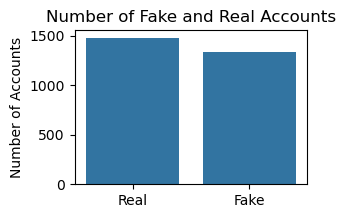

In [9]:
account_counts = data['is_fake'].value_counts()

plt.figure(figsize=(3, 2))
sns.barplot(x=["Real","Fake"], y=account_counts.values)
plt.ylabel('Number of Accounts')
plt.title('Number of Fake and Real Accounts')
plt.show()

## Splitting the data 

##### Before cleaning, we need to split our dataset into train and test data. If we clean and pre-process both true and fake data together, then it leads to over-fitting because our test data would seen the train data. 

In [18]:
data = data.dropna(subset=['description'])
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='is_fake'), data['is_fake'], test_size=0.2, random_state=42, stratify=data['is_fake'])

In [19]:
columns_to_drop = ['id', 'name', 'screen_name', 'created_at', 'url', 'time_zone', 'profile_image_url', 'profile_banner_url', 'profile_background_image_url_https', 'profile_image_url_https', 'profile_sidebar_border_color', 'profile_background_image_url', 'profile_background_color', 'location','updated','profile_link_color', 'utc_offset', 'dataset','profile_background_tile','profile_text_color','profile_sidebar_border_color','profile_sidebar_fill_color','profile_use_background_image','default_profile_image']
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)
X_train = X_train.drop(columns=['verified', 'protected'])
X_test = X_test.drop(columns=['verified', 'protected'])

# EDA

#### To understand the distribution of missing values in our training and test datasets, we used the `missingno` library to generate visual matrices of the missing data. These graphs help us identify columns with missing values and assess the extent of these missing values.



<Figure size 600x300 with 0 Axes>

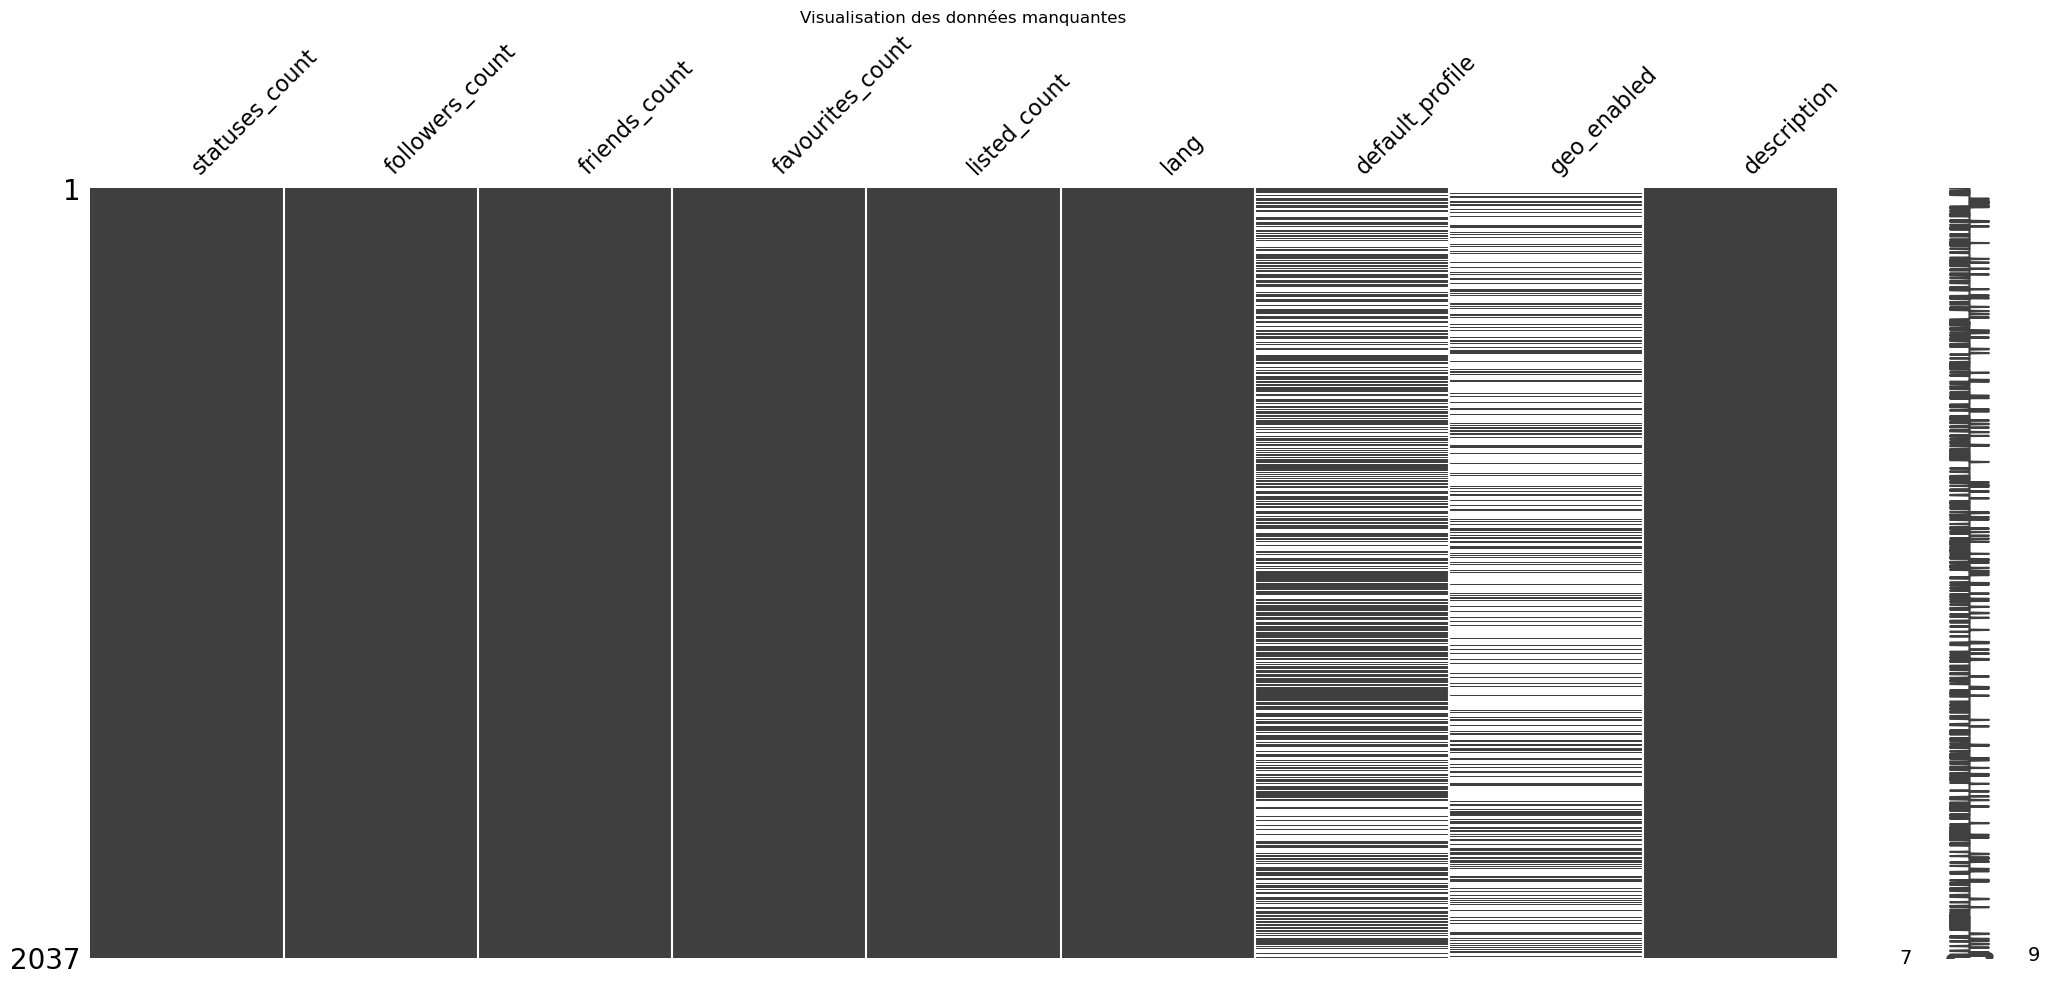

In [20]:

plt.figure(figsize=(6, 3))
msno.matrix(X_train)
plt.title('Visualisation des données manquantes')
plt.show()

<Figure size 600x300 with 0 Axes>

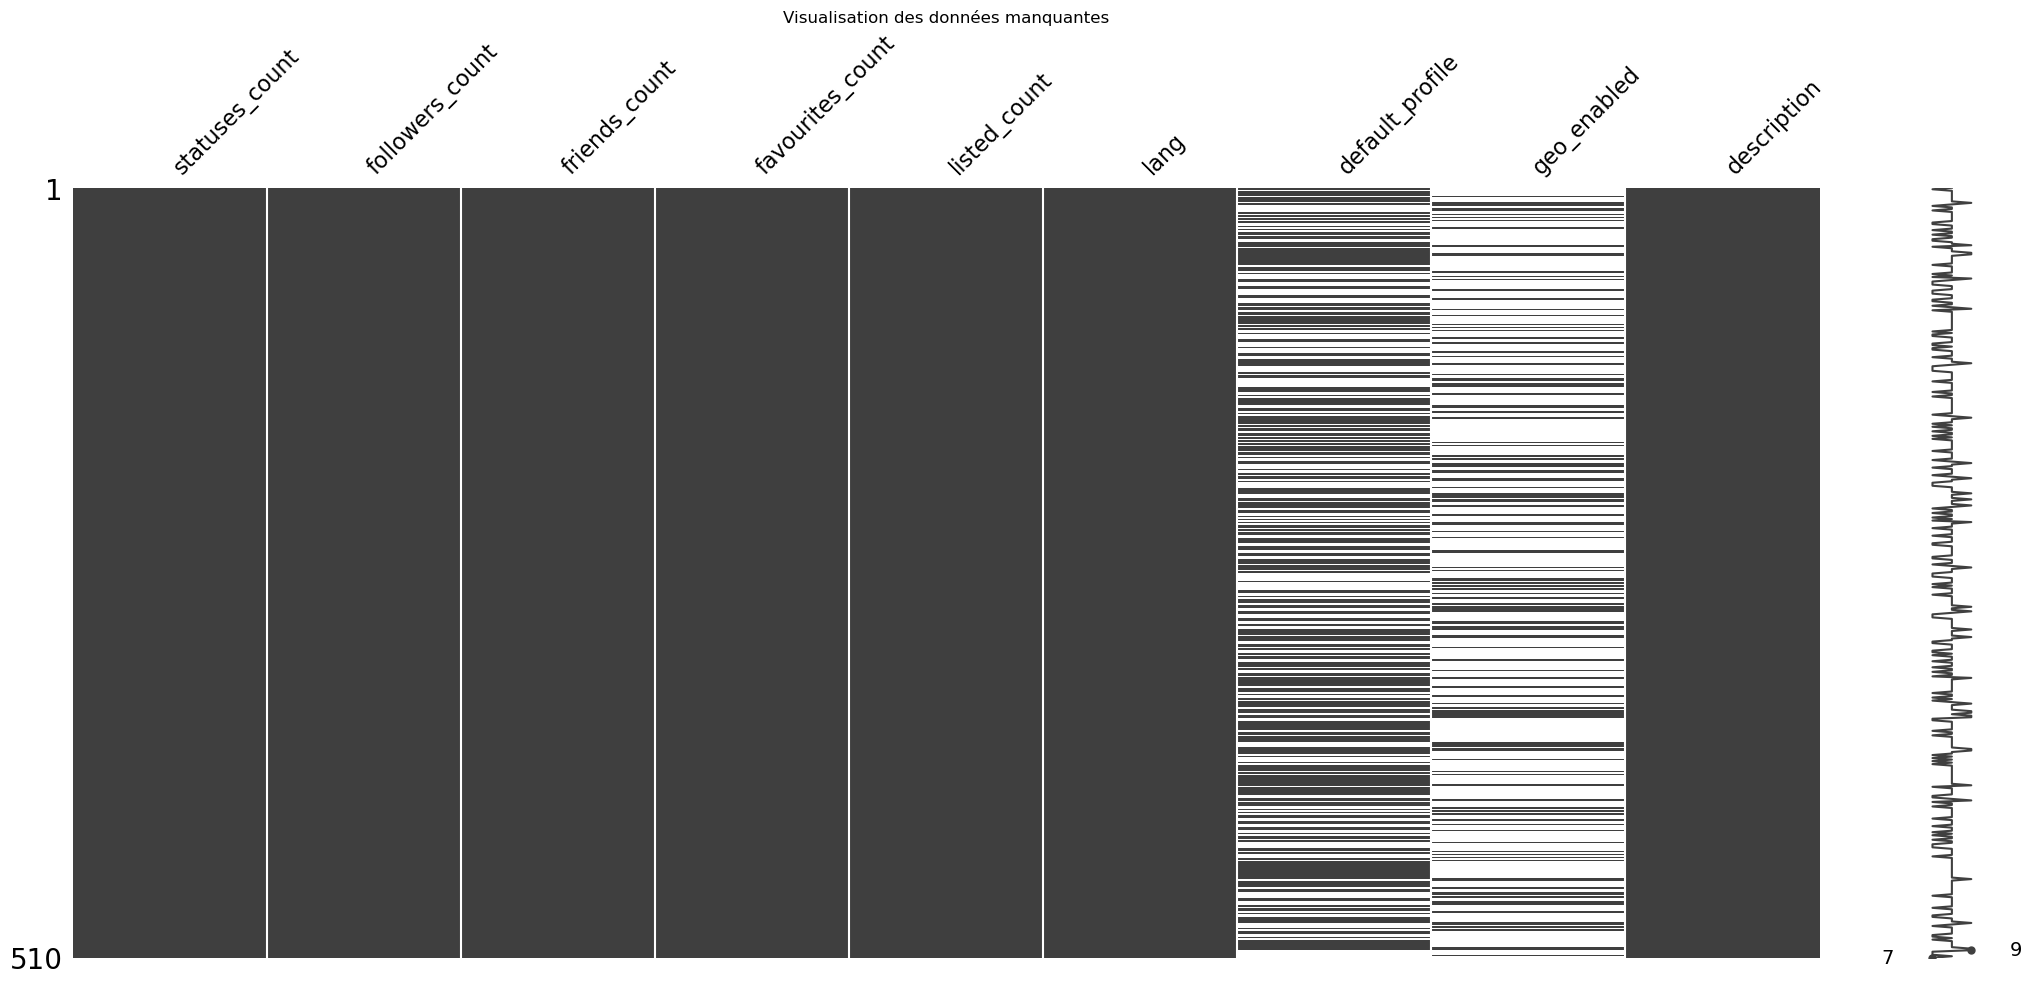

In [21]:

plt.figure(figsize=(6, 3))
msno.matrix(X_test)
plt.title('Visualisation des données manquantes')
plt.show()

## Data Cleaning

#### In this step, we address the missing values in the `X_train` and `X_test` datasets. Specifically, we fill the missing values in the `default_profile` and `geo_enabled` columns with `0`. This ensures that our model does not encounter any issues due to missing data during training and testing.


In [23]:
#Filling Null values for Xtrain
X_train['default_profile'] = X_train['default_profile'].fillna(0) 
X_train['geo_enabled'] = X_train['geo_enabled'].fillna(0)
#X_train = X_train.drop(columns=['default_profile', 'geo_enabled'])


#Filling Null values for Xtrain
X_test['default_profile'] = X_test['default_profile'].fillna(0) 
X_test['geo_enabled'] = X_test['geo_enabled'].fillna(0)
#X_test = X_test.drop(columns=['default_profile', 'geo_enabled'])


<Figure size 600x300 with 0 Axes>

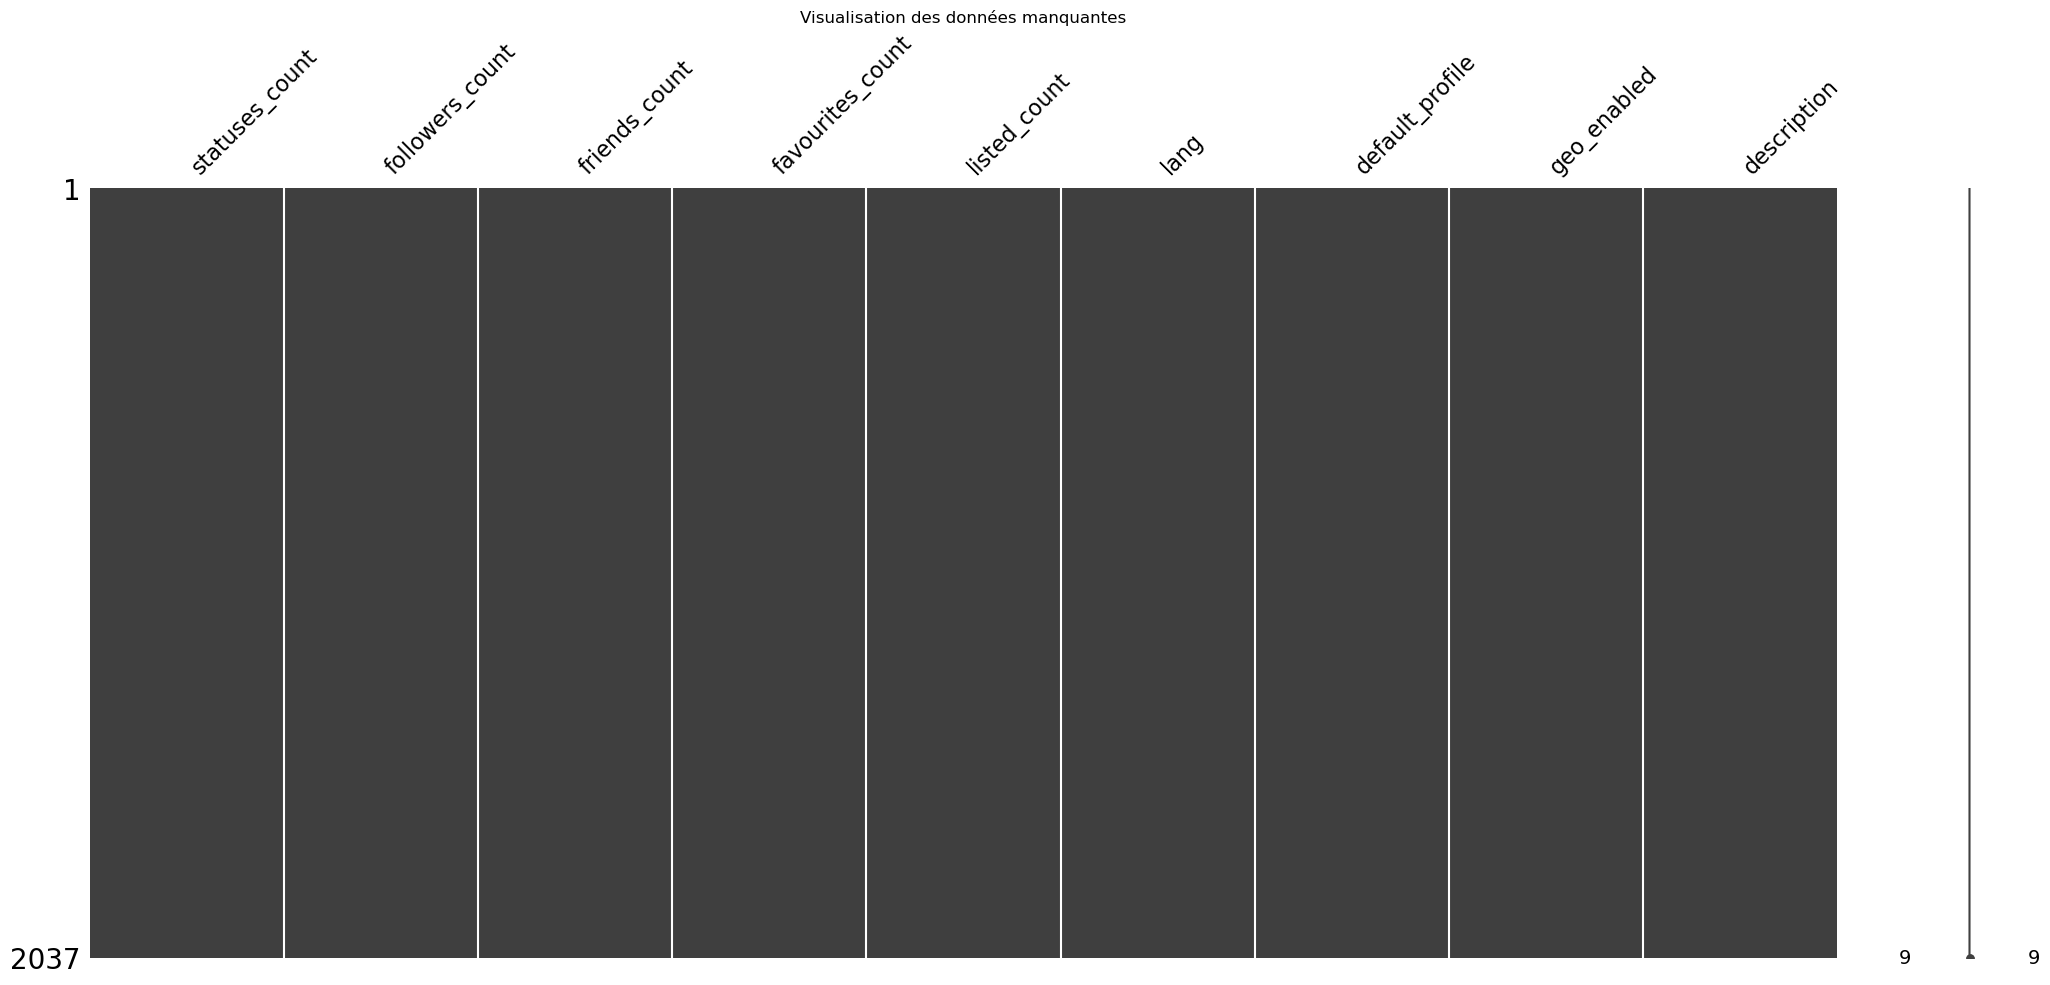

In [24]:
plt.figure(figsize=(6, 3))
msno.matrix(X_train)
plt.title('Visualisation des données manquantes')
plt.show()

<Figure size 600x300 with 0 Axes>

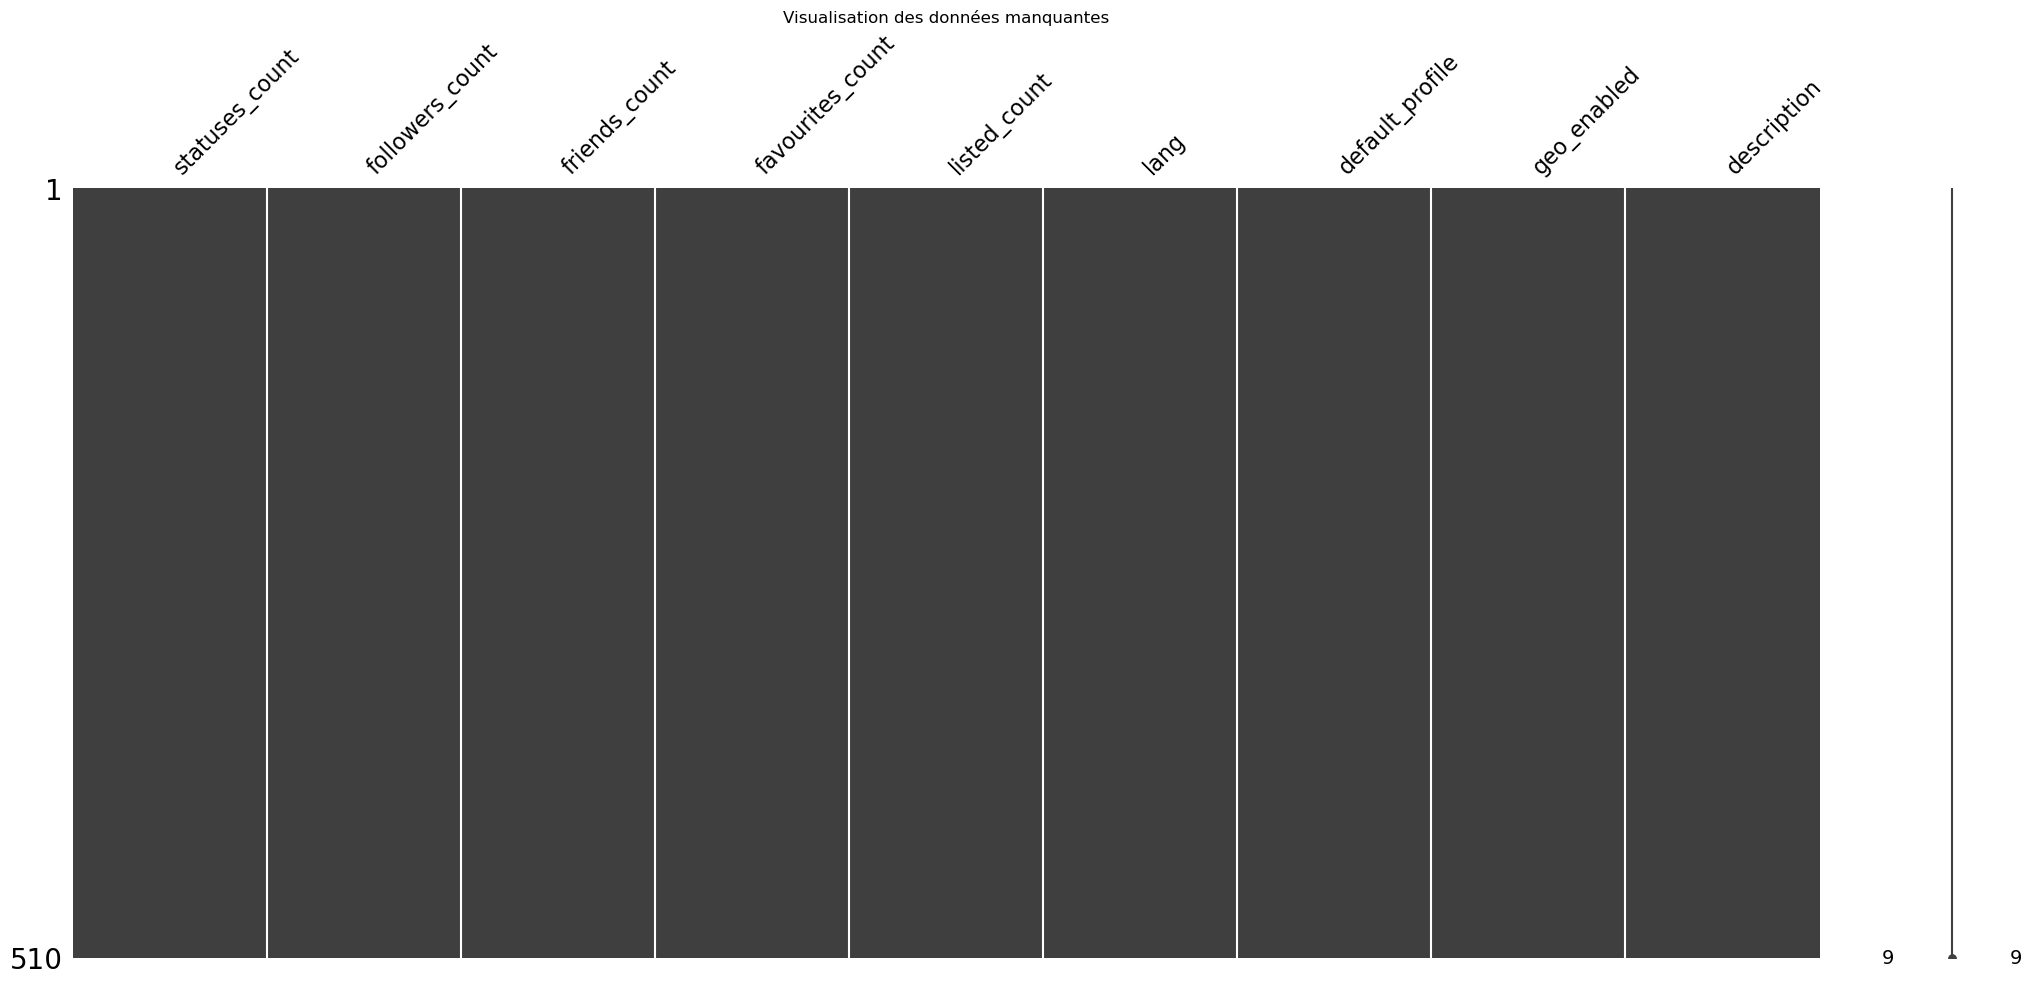

In [25]:
plt.figure(figsize=(6, 3))
msno.matrix(X_test)
plt.title('Visualisation des données manquantes')
plt.show()

In [26]:
blank_percentage = X_train['description'].isna().mean() * 100
non_blank_percentage = 100 - blank_percentage
fig = px.pie(
    names=['Blank', 'Non-Blank'],
    values=[blank_percentage, non_blank_percentage],
    title='Percentage of Blank Cells in Description'
)
fig.show()

In [27]:
lang_counts = X_train['lang'].value_counts().reset_index()
lang_counts.columns = ['Language', 'Count']
fig5 = px.bar(lang_counts, x='Language', y='Count', 
              title='Distribution of Languages', labels={'Language': 'Language', 'Count': 'Count'})
fig5.show()

In [28]:
import plotly.graph_objects as go

# Create bar plots for each metric
fig_combined = go.Figure()

fig_combined.add_trace(go.Bar(
    x=['Fake', 'Real'],  # Assuming 'y_train' contains values like 'Fake' and 'Real'
    y=[X_train[y_train == 1]['followers_count'].mean(), 
       X_train[y_train == 0]['followers_count'].mean()],
    name='Followers Count',
    marker_color='blue'
))

fig_combined.add_trace(go.Bar(
    x=['Fake', 'Real'],
    y=[X_train[y_train == 1]['friends_count'].mean(), 
       X_train[y_train == 0]['friends_count'].mean()],
    name='Friends Count',
    marker_color='green'
))

fig_combined.add_trace(go.Bar(
    x=['Fake', 'Real'],
    y=[X_train[y_train == 1]['statuses_count'].mean(), 
       X_train[y_train== 0]['statuses_count'].mean()],
    name='Statuses Count',
    marker_color='purple'
))

# Update layout
fig_combined.update_layout(
    title='Moyenne des abonnés, amis et statuts par utilisateurs faux/réels',
    xaxis_title='Is Fake',
    yaxis_title='Count',
    barmode='group'
)

fig_combined.show()

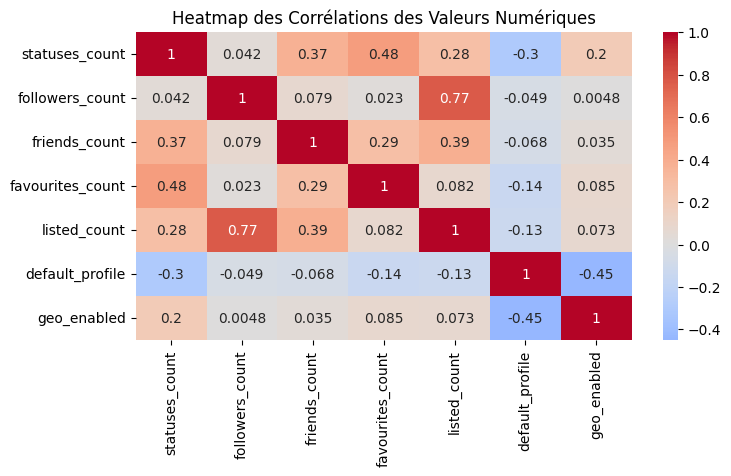

In [134]:
numerical_data = X_train.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap des Corrélations des Valeurs Numériques')
plt.show()

## Data Augmentation

To address class imbalance, we perform data augmentation on the minority class(fake accounts):
 **Random Word Insertion**: Define `insert_random_words` to insert random words into descriptions.
 **Class Count Calculation**: Calculate counts of real and fake users.
 **Minority Class Identification**: Identify the minority class.
 **Data Augmentation**: Augment minority class descriptions.
 **DataFrame Creation**: Create a DataFrame with augmented rows.

This balances the dataset for robust model training.


In [135]:
X_train['is_fake']=y_train
def insert_random_words(text, n_inserts=2):
    words = text.split()
    word_list = list(wordnet.words())
    for _ in range(n_inserts):
        random_word = random.choice(word_list)
        insert_position = random.randint(0, len(words))
        words.insert(insert_position, random_word)
    return ' '.join(words)

# Calculate the difference in counts between real and fake users
real_count = X_train[X_train['is_fake'] == 0].shape[0]
fake_count = X_train[X_train['is_fake'] == 1].shape[0]
difference = abs(real_count - fake_count)

# Augment the descriptions of the minority class
if real_count > fake_count:
    minority_class = X_train[X_train['is_fake'] == 1]
else:
    minority_class = X_train[X_train['is_fake'] == 0]

augmented_rows = []
for i in range(difference):
    row = minority_class.sample(n=1).iloc[0]
    row['description'] = row['description'] if pd.notna(row['description']) else ''
    row['description_aug'] = insert_random_words(row['description'], n_inserts=2)
    augmented_rows.append(row)

# Create a new dataframe with the augmented rows
augmented_df = pd.DataFrame(augmented_rows)

balanced_X_train = pd.concat([X_train, augmented_df.drop(columns=['description_aug'])], ignore_index=True)
y_train = balanced_X_train['is_fake']
X_train.drop(columns=['is_fake'], inplace=True)
balanced_X_train = shuffle(balanced_X_train)



#### Results of data augmentation

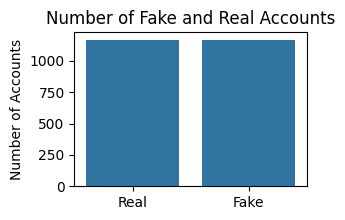

In [136]:
account_counts = y_train.value_counts()

plt.figure(figsize=(3, 2))
sns.barplot(x=["Real","Fake"], y=account_counts.values)
plt.ylabel('Number of Accounts')
plt.title('Number of Fake and Real Accounts')
plt.show()

<Figure size 600x300 with 0 Axes>

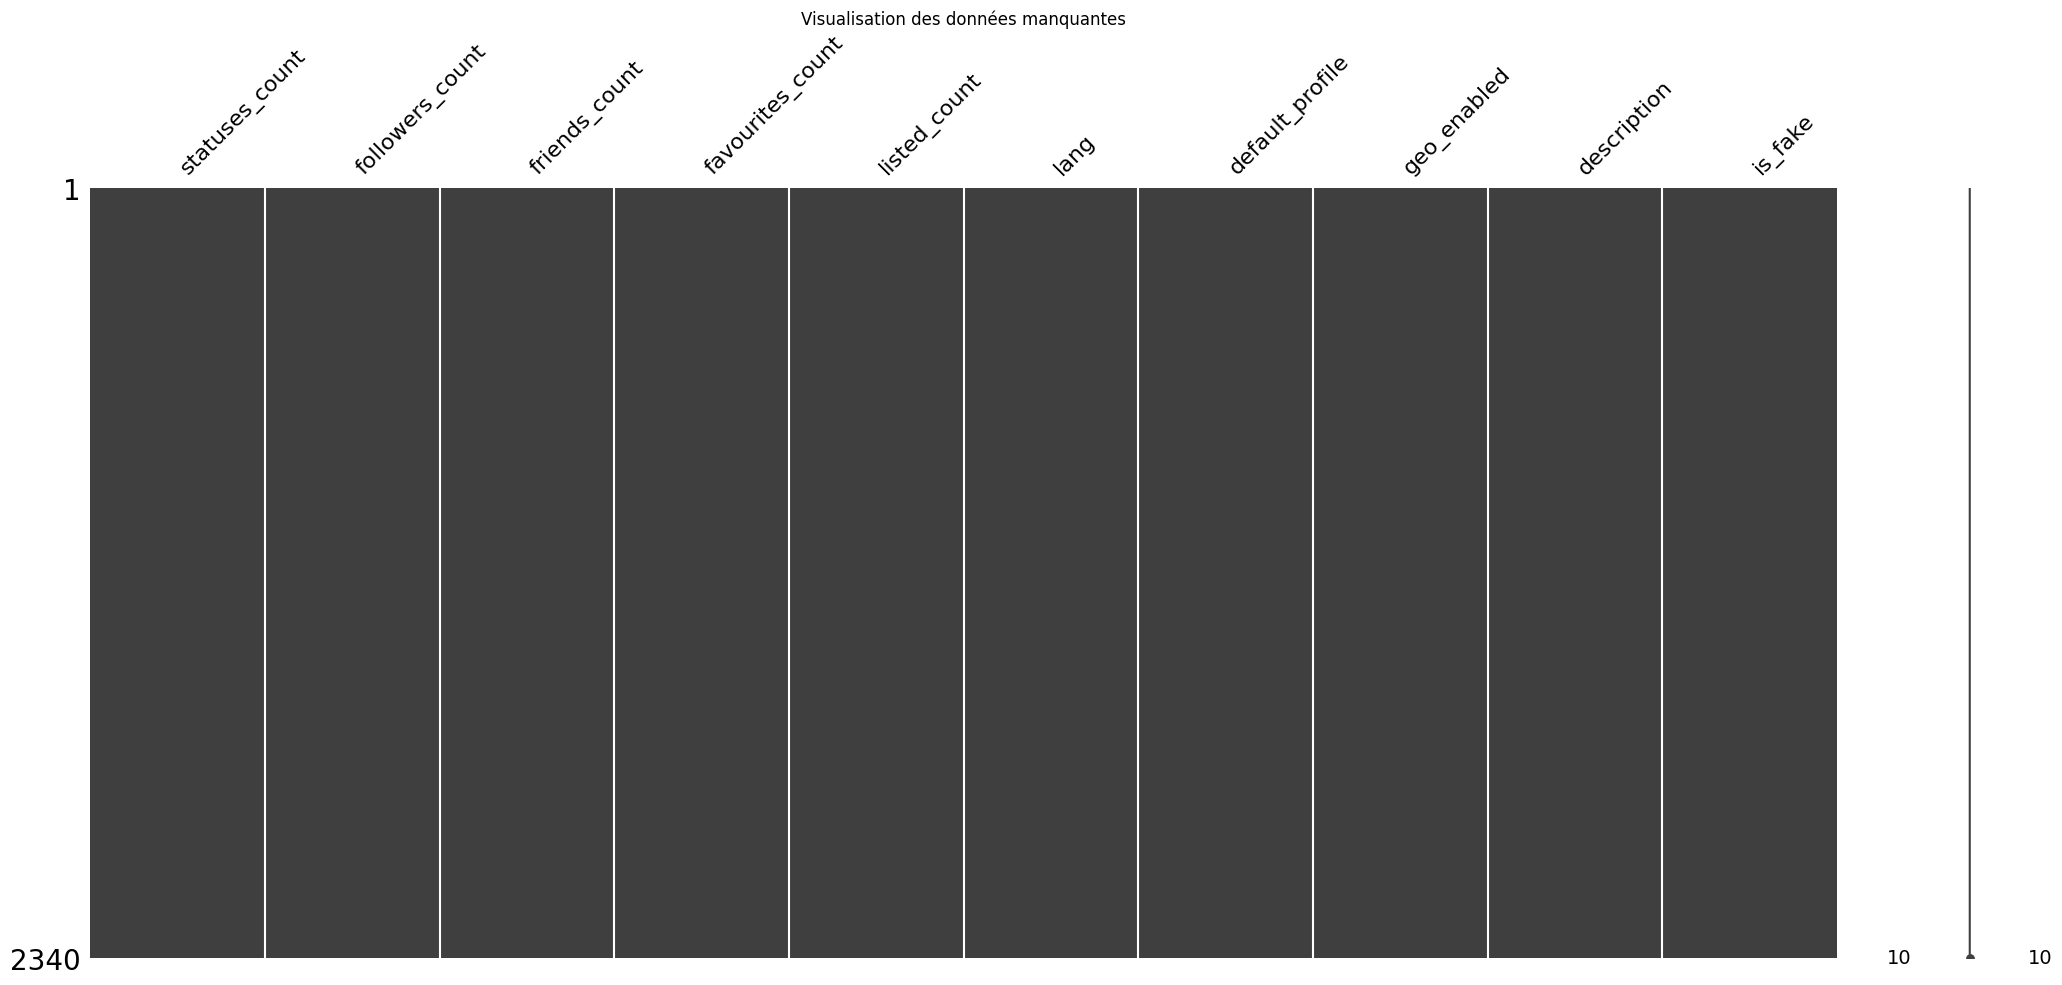

In [ ]:
plt.figure(figsize=(6, 3))
msno.matrix(balanced_X_train)
plt.title('Visualisation des données manquantes')
plt.show()

### Text Preprocessing

In this step, we preprocess the text data in the `description` column of both the training and test datasets. The preprocessing involves the following steps:

1. **Lowercasing and Removing Special Characters**: Convert all text to lowercase and remove any special characters, keeping only letters.
2. **Tokenization**: Split the text into individual words (tokens).
3. **Stopwords Removal**: Remove common stopwords based on the language of the text.
4. **Stemming**: Reduce words to their root form using language-specific stemmers.

The preprocessing function `normalize_document` is defined to perform these steps. We then apply this function to the `description` column of both the training and test datasets, creating a new column `processed_description` with the preprocessed text.

Here is the code used for text preprocessing:



In [138]:
stop_words = {
    'en': set(stopwords.words('english')),
    'it': set(stopwords.words('italian')),
    'es': set(stopwords.words('spanish'))
}

stemmers = {
    'en': SnowballStemmer('english'),
    'it': SnowballStemmer('italian'),
    'es': SnowballStemmer('spanish')
}

# Fonction de prétraitement pour chaque document
def normalize_document(doc, lang):
    # Mise en minuscules et suppression des caractères spéciaux (garde uniquement les lettres)
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags=re.I | re.A)
    doc = doc.lower().strip()
    
    # Tokenisation
    tokens = word_tokenize(doc)
    
    # Filtrer les stopwords en fonction de la langue
    tokens = [token for token in tokens if token not in stop_words.get(lang, set())]
    
    # Appliquer le stemming en fonction de la langue
    stemmer = stemmers.get(lang, SnowballStemmer('english'))
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Recréer le document à partir des tokens
    doc = ' '.join(tokens)
    return doc


# Remplir les valeurs NaN dans la colonne 'description' avec une chaîne vide
balanced_X_train['description'] = balanced_X_train['description'].fillna('')

# Appliquer le prétraitement à la colonne 'description' en utilisant la langue spécifiée
balanced_X_train['processed_description'] = balanced_X_train.apply(lambda row: normalize_document(row['description'], row['lang']), axis=1)

# Afficher les descriptions prétraitées
balanced_X_train[['description', 'processed_description']]

X_test['description'] = X_test['description'].fillna('')
X_test['processed_description'] = X_test.apply(lambda row: normalize_document(row['description'], row['lang']), axis=1)

# Afficher les descriptions prétraitées
X_test[['description', 'processed_description']]


,description,processed_description
2621,http://t.co/QqJ2aiKi is coming..,httptcoqqjaiki come
837,In the future everyone will be world-famous fo...,the futur everyon will be worldfamous for minutes
1646,"Sharp, sensitiv, woman of the South. Married w...",sharp sensitiv woman south marri id
2310,"Artist Development, Artist Management, Marketi...",artist develop artist manag market promot even...
2751,Chasing a tale of a loe-drawn distant memor.,chase tale loedrawn distant memor
...,...,...
286,"Passione per innovazione,musica progressive ro...",passion innovazionemus progress rock saggistic...
754,"Love the life you live, live the life you love...",lov the lif you liv liv the lif you lov bob ma...
1325,"Chi ama davvero ama il mondo intero, non solta...",ama davver ama mond inter soltant individu par...
462,â€ŽDon't settle down and sit in on place. Move...,dont settl sit place move around nomad make da...


# Prediction

#### Data vectorization

In [139]:

encoder = OneHotEncoder(sparse=False)
X_train_cat = encoder.fit_transform(balanced_X_train[['lang']])
X_test_cat = encoder.transform(X_test[['lang']])

c:\Users\Chaimaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [140]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(balanced_X_train['processed_description']).toarray()
X_test_tfidf = tfidf.transform(X_test['processed_description'] ).toarray()

In [141]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(balanced_X_train[['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count','geo_enabled','default_profile']])
X_test_scaled = scaler.transform(X_test[['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count','geo_enabled','default_profile']])

# Concatenate all features
X_train = np.hstack((X_train_tfidf, X_train_scaled, X_train_cat))
X_test = np.hstack((X_test_tfidf, X_test_scaled, X_test_cat))

#### Applying the models

In [142]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")

Random Forest Accuracy: 0.57
Gradient Boosting Accuracy: 0.76
Logistic Regression Accuracy: 0.63
K-Nearest Neighbors Accuracy: 0.55
Support Vector Machine Accuracy: 0.94
Decision Tree Accuracy: 0.52


### Hyperparameter tuning

In [ ]:

# Define classifiers and hyperparameter grids
classifiers = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=200),
        "params": {
            "C": [0.1, 1, 10, 100],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 10],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Support Vector Machine": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5, 10],
            "criterion": ["gini", "entropy"]
        }
    }
}

# Store the best parameters and scores for each model
best_params = {}
best_scores = {}

# Iterate through each classifier
for classifier_name, clf_dict in classifiers.items():
    print(f"Running GridSearchCV for {classifier_name}...")

    # Use a pipeline for scaling where necessary
    if classifier_name in ["Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", clf_dict["model"])
        ])
    else:
        pipe = Pipeline([
            ("classifier", clf_dict["model"])
        ])
    
    # Set up the GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid={'classifier__' + k: v for k, v in clf_dict["params"].items()},
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5),
        verbose=1,
        n_jobs=-1
    )

    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Store best parameters and best score
    best_params[classifier_name] = grid_search.best_params_
    best_scores[classifier_name] = grid_search.best_score_
    print(f"Best Parameters for {classifier_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score for {classifier_name}: {grid_search.best_score_}\n")

# Summary of results
print("Summary of Best Parameters and Scores:")
for clf_name in best_params:
    print(f"{clf_name}: Best Params = {best_params[clf_name]}, Best Score = {best_scores[clf_name]}")


Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Cross-Validation Score for Random Forest: 0.5252136752136752

Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Gradient Boosting: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best Cross-Validation Score for Gradient Boosting: 0.5076923076923077

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Logistic Regression: {'classifier__C': 100, 'classifier__solver': 'liblinear'}
Best Cross-Validation Score for Logistic Regression: 0.5183760683760683

Running GridSearchCV for K-Nearest Neighbors...
Fitting 5 folds for each of 12 candidates, totallin